# 1. Lending Club Risk Analysis - Introduction

With technological advances, people can now invest in other people's loans using online peer-to-peer lending platforms like, Lending Club. So far the most straightforward metric for identifying risk / reward is available to investors: higher interest rate means more risk (lower investment grade), lower interest rate means less risk (higher investment grade). Attempt to identifying other features that should be used to identify whether a loan is going to performs poorly (Default or be Charged Off) or will do just fine (Fully Paid) using Machine Leaning techniques.

Goal of the project:

Given Lending Club data on 2M+ loans, what drives a loan to default? Can we build a model that would identify problematic loans early on?

Background knowledge:

The term “default” lacks specificity, as many credit card companies have moved away from using it to describe overdue card payments. In the strictest terms, an account is in default if you haven’t made a payment by the due date. However, the term has come to be used to describe any debt that the card issuer no longer expects to be paid in full.

When a credit card company has decided that the outstanding debt they’re owed is unlikely to be paid at all, they will typically “charge-off” the debt. What this means to the card issuer is the entire amount of the outstanding debt, plus interest and fees, goes onto their books as an uncollectable debt.

Target:

Out target then is to predict Charged Off and Defaults together, collectively, they will represent "bad" loans.

<b> This is a draft of an ongoing project <b>

## 1.1 Project Structure
Now that we have an idea what a "bad" loan is, let us define labels for bad loans:
- Charged Off
- Default

Let's do the same for good loans and provide some definition. For the purposes of this analysis, we choose good loans to have the following charachteristics:
- Fully Paid

<b> We will thus ignore In Grace Period and Current loans, as we do not know whether they are "good" or "bad" and they will confuse our model. <\b>

In [2]:
# Standard for Data
import pandas as pd
import numpy as np
import math
import pandas.api.types as ptypes

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Machine
import os

# Aesthetics for Coding
import warnings
warnings.simplefilter(action='ignore', category = DeprecationWarning)
warnings.simplefilter(action='ignore', category = FutureWarning)

# 2. Data Processing

## 2.1 Dataset
I first started this project using [LC dataset provided by Wendy Kan](https://www.kaggle.com/wendykan/lending-club-loan-data) but realized that this dataset is missing a lot of useful information, like FICO scores.So I am now using the [dataset provided by Nathan George](https://www.kaggle.com/wordsforthewise/lending-club), which has all available features.

In [3]:
data = pd.read_csv('datasets_902_370089_accepted_2007_to_2018Q4.csv', parse_dates=['issue_d'], infer_datetime_format=True)

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(data.issue_d.describe())
data.head()

count                 2260668
unique                    139
top       2016-03-01 00:00:00
freq                    61992
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
data_use = data[(data.issue_d >= '2017-01-01')]

In [70]:
data_use.shape

(938821, 151)

We have 151 features available and ~1M loans to use as our training / validation / test sets to build a model. For the usefulness of this project, it is vital to keep in mind which features we should use to build this model, as not all features are available to investors when they make a decision to invest.

To better understand what each features is we will use [LC Data Dictionary](https://www.kaggle.com/wendykan/lending-club-loan-data)

In [71]:
var_description = pd.read_excel('LCDataDictionary.xlsx')
var_description.dropna(inplace=True)
var_description.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [72]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000, "display.max_colwidth", 1000): 
        display(df)

In [238]:
# Lookup Feature here:
display_all(var_description[var_description.LoanStatNew.str.contains('dti')])

,LoanStatNew,Description
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
17,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


## 2.2 Data Cleaning

### 2.2.1 Percent missing

In [500]:
def percent_null(df):
    num_null = pd.Series([sum(df[col].isnull()) for col in df.columns])
    percent_null_df = pd.DataFrame({'col':df.columns, 'Missing Values':num_null, 
                                    '% of Total Values':100*num_null/len(df)}).sort_values(by = '% of Total Values', ascending=False)
    percent_null_df = percent_null_df.loc[percent_null_df['% of Total Values'] != 0].round(1)
    percent_null_df.set_index('col', inplace = True)
    percent_null_df.index.name = None
    return percent_null_df
percent_null_df = percent_null(data_use)
display_all(percent_null_df.head())

,Missing Values,% of Total Values
member_id,938821,100.0
desc,938821,100.0
orig_projected_additional_accrued_interest,936193,99.7
hardship_length,935556,99.7
payment_plan_start_date,935556,99.7


In [246]:
sum(data_use.dti.isna())/len(data_use.dti)

0.0017532628690666273

In [76]:
percent_null_df.shape

(63, 2)

Let's delete features that have more than 90% missing values

In [77]:
to_del = list(percent_null_df[percent_null_df['% of Total Values'] > 90.0].index)
to_del.extend(['url', 'emp_title', 'title']); len(to_del)

26

### 2.2.2 Setting up a Target Varaible
We will first "clean" loan_status columns for the entire dataset to abide by our abovementioned project structure.

In [78]:
total_loan_status = data_use.loan_status.copy()
total_loan_status.groupby(total_loan_status).count()

loan_status
Charged Off            48015
Current               689032
Default                   28
Fully Paid            177596
In Grace Period         5830
Late (16-30 days)       3095
Late (31-120 days)     15225
Name: loan_status, dtype: int64

In [79]:
data_use_tgt = data_use.loc[~(data_use.loan_status == 'Current') & ~(data_use.loan_status == 'In Grace Period')
                               & ~(data_use.loan_status == 'Late (16-30 days)')
                               & ~(data_use.loan_status == 'Late (31-120 days)'),:]

In [80]:
total_target = data_use_tgt.loan_status
print(len(total_target))
total_target.groupby(by = total_target).count()

225639


loan_status
Charged Off     48015
Default            28
Fully Paid     177596
Name: loan_status, dtype: int64

In [141]:
test_df = data_use_tgt.sample(frac=0.1, random_state = 101)

# work_df is for training and validating; and deleting to_del
work_df = data_use_tgt[~data_use_tgt.index.isin(test_df.index)].drop(to_del, axis = 1)
target_raw = work_df.loan_status.copy()
work_df = work_df.drop(['loan_status'], axis = 1)

In [142]:
test_df.loan_status.value_counts()/len(test_df.loan_status)

Fully Paid     0.785721
Charged Off    0.214191
Default        0.000089
Name: loan_status, dtype: float64

In [143]:
target_raw.value_counts()/len(target_raw)

Fully Paid     0.787231
Charged Off    0.212641
Default        0.000128
Name: loan_status, dtype: float64

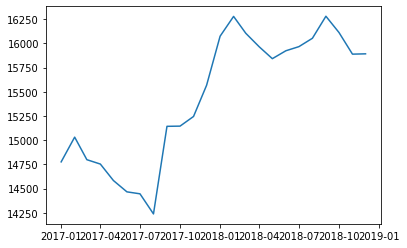

In [223]:
to_plot_loan_amnt = data_use.groupby(by='issue_d')['loan_amnt'].mean()
to_plot_loan_amnt.head()
plt.plot(to_plot_loan_amnt.index, to_plot_loan_amnt);

Looks like loan amount is increasing as time goes on - this could potentially be a problem as Random Forests do not do well with time sensitive variables

### 2.2.3 Deleting leaking variables
From our previous analysis, we have identified a few leaking variables. We are going to delete these before training our model.

In [144]:
leak_feat = ['recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
             'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'debt_settlement_flag', 
             'out_prncp_inv', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_flag']
work_df = work_df.drop(leak_feat, axis = 1)

### 2.2.4 Converting work dataframe into numeric only dataframe
To ensure that we can train our random forest model, we need to convert all object data type columns to numeric ones.


In [475]:
work_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [146]:
# Fixing time variables
list_time_vars = list(work_df.columns[work_df.columns.str.contains(r'_d$')])

attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
list_time_vars.extend(['earliest_cr_line', 'sec_app_earliest_cr_line'])
for var in list_time_vars:
    if pd.isnull(work_df[var]).sum(): 
        work_df[var+'_na'] = pd.isnull(work_df[var])
        work_df[var] = work_df[var].fillna(0)
    temp = pd.to_datetime(work_df[var], infer_datetime_format=True)
    work_df[var] = pd.to_datetime(work_df[var], infer_datetime_format=True).astype('int64')
    for i in attr:
        work_df[var+'_'+i] = getattr(temp.dt, i.lower())

In [147]:
# Cleaning individual columns
work_df.emp_length = work_df.emp_length.replace({'< 1 year': '0 years', '10+ years': '11 years'})
work_df.emp_length = work_df.emp_length.str.extract('([0-9]{1,2})', expand = False).fillna(value = 0).astype('int')
work_df.term = work_df.term.str.extract('([0-9]{1,2})', expand = False).fillna(value = 0).astype('int')
work_df.grade = pd.Categorical(work_df.grade, ordered = True, categories = sorted(work_df.grade.unique(), reverse = True))
work_df.sub_grade = pd.Categorical(work_df.sub_grade, ordered = True, categories = sorted(work_df.sub_grade.unique(), reverse = True))

In [164]:
# Feature engineering
work_df['annual_inc_joint' + 'na'] = pd.isnull(work_df['annual_inc_joint'])
work_df['annual_inc_joint'] = work_df['annual_inc_joint'].fillna(work_df['annual_inc'])
work_df['avg_fico'] = pd.concat([work_df.fico_range_high, work_df.fico_range_low], axis = 1).mean(axis=1)
work_df['loan_amnt_to_inc_ratio'] = work_df.loan_amnt / work_df.annual_inc_joint
work_df.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace = True)

In [165]:
display_all(work_df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,disbursement_method,issue_d_Year,issue_d_Month,issue_d_Week,issue_d_Day,issue_d_Dayofweek,issue_d_Dayofyear,issue_d_Is_month_end,issue_d_Is_month_start,issue_d_Is_quarter_end,issue_d_Is_quarter_start,issue_d_Is_year_end,issue_d_Is_year_start,earliest_cr_line_Year,earliest_cr_line_Month,earliest_cr_line_Week,earliest_cr_line_Day,earliest_cr_line_Dayofweek,earliest_cr_line_Dayofyear,earliest_cr_line_Is_month_end,earliest_cr_line_Is_month_start,earliest_cr_line_Is_quarter_end,earliest_cr_line_Is_quarter_start,earliest_cr_line_Is_year_end,earliest_cr_line_Is_year_start,sec_app_earliest_cr_line_na,sec_app_earliest_cr_line_Year,sec_app_earliest_cr_line_Month,sec_app_earliest_cr_line_Week,sec_app_earliest_cr_line_Day,sec_app_earliest_cr_line_Dayofweek,sec_app_earliest_cr_line_Dayofyear,sec_app_earliest_cr_line_Is_month_end,sec_app_earliest_cr_line_Is_month_start,sec_app_earliest_cr_line_Is_quarter_end,sec_app_earliest_cr_line_Is_quarter_start,sec_app_earliest_cr_line_Is_year_end,sec_app_earliest_cr_line_Is_year_start,annual_inc_jointna,avg_fico,dti_na,revol_util_na,dti_joint_na,il_util_na,all_util_na,avg_cur_bal_na,bc_util_na,num_tl_120dpd_2m_na,percent_bc_gt_75_na,revol_bal_joint_na,sec_app_fico_range_low_na,sec_app_fico_range_high_na,sec_app_inq_last_6mths_na,sec_app_mort_acc_na,sec_app_open_acc_na,sec_app_revol_util_na,sec_app_open_act_il_na,sec_app_num_rev_accts_na,sec_app_chargeoff_within_12_mths_na,sec_app_collections_12_mths_ex_med_na,loan_amnt_to_inc_ratio
421101,201373,3000.0,3000.0,3000.0,36,7.34,93.10,7,32,9,5,52000.0,2,1519862400000000000,1,6,876,47,0.58,0.0,883612800000000000,0.0,26.0,124.0,7.0,0.0,141.0,0.5,30.0,2,0.0,764.0,760.0,0.0,226.0,1.0,1,52000.0,18.6,0,0.0,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,73.0,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,202.0,7.0,202.0,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,1.0,7.0,0.0,0.0,0.0,1.0,96.7,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,24666.0,665.0,669.0,0,0.0,1.0,10.0,59.3,2.0,11.0,0.0,0.0,1,2018,3,9,1,3,60,False,True,False,False,False,False,1998,1,1,1,3,1,False,True,False,True,False,True,True,1970,1,1,1,3,1,False,True,False,True,False,True,False,762.0,False,False,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,0.057692
421113,201408,5000.0,5000.0,5000.0,36,11.

For some of the numeric features the missing values should be filled using the maximum value of the respective columns so these features are placed in the list fill_max. For example, the feature mths_since_last_record indicates the number of months since the last record (like bankruptcy, foreclosure, tax liens, etc.) so if missing, one should assume that no records were made and the number of months since the "last" record should be a maximum.

In [166]:
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq']

work_df[fill_max] = work_df[fill_max].fillna(work_df[fill_max].max())

In [167]:
# Converting object variables into categorical and imputing NA values
for n,c in work_df.items():
    if ptypes.is_numeric_dtype(c):
        if pd.isnull(c).sum():
            work_df[n+'_na'] = pd.isnull(c)
            work_df[n] = c.fillna(c.median())
    if ptypes.is_string_dtype(c):
        work_df[n] = pd.Categorical(c, ordered = True)
        work_df[n] = work_df[n].cat.codes + 1

In [168]:
display_all(work_df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,disbursement_method,issue_d_Year,issue_d_Month,issue_d_Week,issue_d_Day,issue_d_Dayofweek,issue_d_Dayofyear,issue_d_Is_month_end,issue_d_Is_month_start,issue_d_Is_quarter_end,issue_d_Is_quarter_start,issue_d_Is_year_end,issue_d_Is_year_start,earliest_cr_line_Year,earliest_cr_line_Month,earliest_cr_line_Week,earliest_cr_line_Day,earliest_cr_line_Dayofweek,earliest_cr_line_Dayofyear,earliest_cr_line_Is_month_end,earliest_cr_line_Is_month_start,earliest_cr_line_Is_quarter_end,earliest_cr_line_Is_quarter_start,earliest_cr_line_Is_year_end,earliest_cr_line_Is_year_start,sec_app_earliest_cr_line_na,sec_app_earliest_cr_line_Year,sec_app_earliest_cr_line_Month,sec_app_earliest_cr_line_Week,sec_app_earliest_cr_line_Day,sec_app_earliest_cr_line_Dayofweek,sec_app_earliest_cr_line_Dayofyear,sec_app_earliest_cr_line_Is_month_end,sec_app_earliest_cr_line_Is_month_start,sec_app_earliest_cr_line_Is_quarter_end,sec_app_earliest_cr_line_Is_quarter_start,sec_app_earliest_cr_line_Is_year_end,sec_app_earliest_cr_line_Is_year_start,annual_inc_jointna,avg_fico,dti_na,revol_util_na,dti_joint_na,il_util_na,all_util_na,avg_cur_bal_na,bc_util_na,num_tl_120dpd_2m_na,percent_bc_gt_75_na,revol_bal_joint_na,sec_app_fico_range_low_na,sec_app_fico_range_high_na,sec_app_inq_last_6mths_na,sec_app_mort_acc_na,sec_app_open_acc_na,sec_app_revol_util_na,sec_app_open_act_il_na,sec_app_num_rev_accts_na,sec_app_chargeoff_within_12_mths_na,sec_app_collections_12_mths_ex_med_na,loan_amnt_to_inc_ratio
421101,201373,3000.0,3000.0,3000.0,36,7.34,93.10,7,32,9,5,52000.0,2,1519862400000000000,1,6,876,47,0.58,0.0,883612800000000000,0.0,26.0,124.0,7.0,0.0,141.0,0.5,30.0,2,0.0,764.0,760.0,0.0,226.0,1.0,1,52000.0,18.6,0,0.0,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,73.0,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,202.0,7.0,202.0,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,1.0,7.0,0.0,0.0,0.0,1.0,96.7,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,24666.0,665.0,669.0,0,0.0,1.0,10.0,59.3,2.0,11.0,0.0,0.0,1,2018,3,9,1,3,60,False,True,False,False,False,False,1998,1,1,1,3,1,False,True,False,True,False,True,True,1970,1,1,1,3,1,False,True,False,True,False,True,False,762.0,False,False,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,0.057692
421113,201408,5000.0,5000.0,5000.0,36,11.

In [169]:
work_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

Text(0, 0.5, 'Data type')

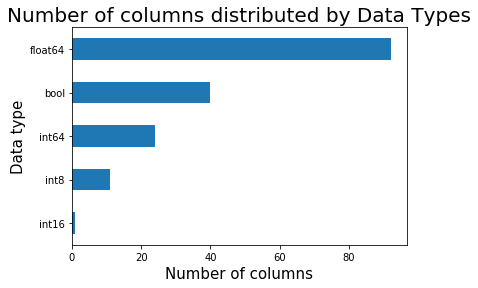

In [170]:
work_df.dtypes.value_counts().sort_values().plot(kind = 'barh');
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

### 2.2.5 Multicollinearity
Although highly correlated features (multicollinearity) aren't a problem for the machine learning models based on decision trees (as used here), these features decrease importances of each other and can make feature analysis more difficult. Therefore, we calculate feature correlations and remove the features with very high correlation coefficients before applying machine learning.

In [171]:
from itertools import combinations
from scipy.stats import pearsonr

num_feat = work_df.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(work_df[comb[0]], work_df[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [476]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
#high_corr_num

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [173]:
np.unique(high_corr_num[:, 1])

array(['annual_inc_joint', 'earliest_cr_line_Dayofyear',
       'earliest_cr_line_Year', 'funded_amnt', 'funded_amnt_inv', 'grade',
       'installment', 'issue_d', 'issue_d_Dayofyear',
       'mo_sin_old_rev_tl_op', 'num_rev_tl_bal_gt_0', 'num_sats',
       'sec_app_earliest_cr_line', 'sec_app_earliest_cr_line_Dayofyear',
       'sec_app_earliest_cr_line_Week', 'sec_app_earliest_cr_line_Year',
       'sec_app_fico_range_high', 'sub_grade', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_il_high_credit_limit'], dtype='<U34')

In [367]:
X_tr_vl = work_df.drop(np.unique(high_corr_num[:, 1]), axis=1, errors='ignore')

The question we must answer is, do the FICO credit scores information into the future? Recall a column is considered leaking information when especially it won’t be available at the time we use our model – in this case when we use our model on future loans.

After looking through some of the feature documentation we identify that 'last_fico_range_low' and 'last_fico_range_high' are indeed leaking featurs. So we must drop them, as they wouldn't be available for the loan origination analysis.


In [368]:
leak_fico_columns = ['last_fico_range_high','last_fico_range_low']
corr_columns = ['id', 'zip_code']
X_tr_vl = pd.concat([X_tr_vl, work_df.issue_d, work_df.grade], axis = 1).drop(leak_fico_columns, axis = 1)
X_tr_vl = X_tr_vl.drop(corr_columns, axis = 1)

# 3. Modeling
## 3.1 First Random Forest Model
The goal of his first random forest is to give us some insight into what columns are most important, what is working and what needs adjustments. 

In [369]:
import math
def rmse(predicted, true_vals): return math.sqrt(((predicted-true_vals)**2).mean())

def print_score(m, X_t, X_v, y_t, y_v):
    train_pred = m.predict(X_t)
    valid_pred = m.predict(X_v)
    res = pd.DataFrame({'train_rmse':[rmse(train_pred, y_t)], 'valid_rmse':[rmse(valid_pred, y_v)],
                        'train_recall':[metrics.recall_score(y_t, train_pred)], 
                        'valid_recall':[metrics.recall_score(y_v, valid_pred)],
                        'train_precision':[metrics.precision_score(y_t, train_pred)], 
                        'valid_precision':[metrics.precision_score(y_v, valid_pred)],
                        'train_accuracy':[metrics.accuracy_score(y_t, train_pred)],
                        'valid_accuracy':[metrics.accuracy_score(y_v, valid_pred)]
                       })
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    return res

In [370]:
target_raw.value_counts()

Fully Paid     159867
Charged Off     43182
Default            26
Name: loan_status, dtype: int64

In [371]:
target = target_raw.copy()
target.loc[(target == 'Charged Off') | (target == 'Default')] = 0
target[~target.index.isin(target[target==0].index)] = 1

print(target.value_counts()/len(target))

X = X_tr_vl.copy()

1    0.787231
0    0.212769
Name: loan_status, dtype: float64


In [372]:
def train_valid_dfs(df, y_tgt, prop_tr):
    """ Creates train and validation sets using predefined work_df and target sets"""
    np.random.seed(101)
    idxs = y_tgt.groupby(y_tgt).apply(lambda x: x.sample(frac=prop_tr)).index.get_level_values(1)
    y_train = y_tgt.loc[idxs]
    
    y_valid = y_tgt[~y_tgt.index.isin(y_train.index)]
    
    train_df = df.loc[idxs]
    valid_df = df[~df.index.isin(train_df.index)]
    
    return train_df, valid_df, y_train, y_valid

X_train, X_valid, y_train, y_valid = train_valid_dfs(X, target, 0.7)

In [373]:
y_train = y_train.astype('int')

y_valid = y_valid.astype('int')

In [374]:
y_train.value_counts()

1    111907
0     30246
Name: loan_status, dtype: int64

In [375]:
y_train_dup.value_counts()

0    120984
1    111907
Name: loan_status, dtype: int64

In [376]:
y_valid.value_counts()

1    47960
0    12962
Name: loan_status, dtype: int64

In [377]:
# Random Forest Model with default parameters and data as is
m_rf = RandomForestClassifier(n_jobs = -1)
m_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [378]:
print_score(m_rf, X_train, X_valid, y_train, y_valid)

,train_rmse,valid_rmse,train_recall,valid_recall,train_precision,valid_precision,train_accuracy,valid_accuracy
0,0.0,0.454849,1.0,0.984862,1.0,0.799059,1.0,0.793113


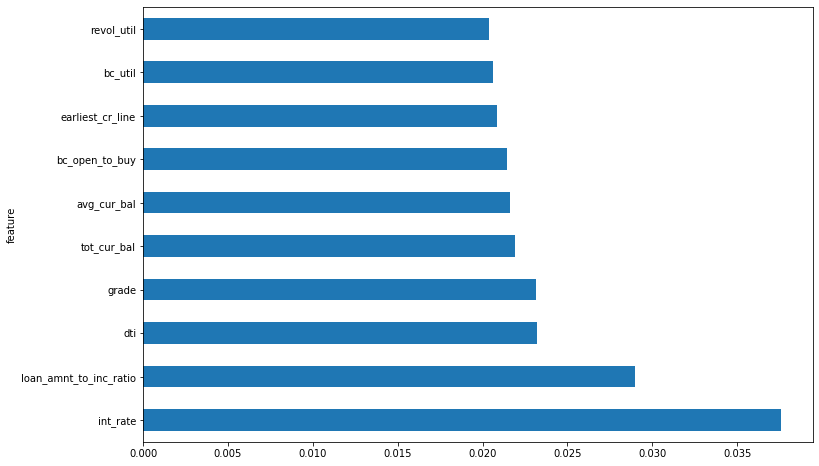

In [379]:
feat_imp1 = pd.DataFrame({'feature' : X_train.columns, 'imp' : m_rf.feature_importances_}).sort_values(by='imp', ascending = False)
feat_imp1[:10].plot('feature', 'imp', 'barh', figsize=(12,8), legend = False);

In [380]:
print(metrics.classification_report(y_valid, m_rf.predict(X_valid)))
print(metrics.confusion_matrix(y_valid, m_rf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.60      0.08      0.15     12962
           1       0.80      0.98      0.88     47960

    accuracy                           0.79     60922
   macro avg       0.70      0.53      0.51     60922
weighted avg       0.76      0.79      0.73     60922

[[ 1084 11878]
 [  726 47234]]


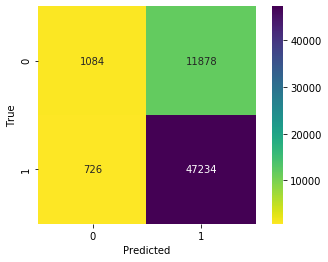

In [381]:
cm = metrics.confusion_matrix(y_valid, m_rf.predict(X_valid))
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

The random forest model we trained is performing OK. Unfortunately is doing a poor job at identifying default loans and is biased towards class 1, the most prominent class. Evidence to support this claim is a low recall rate on 0 class and low precision for class 1. Solutions:
- Upsampling the 0 class
- Reduce the number of features available to train by only keeping important features as we may be facing overfitting
- Increase max_samples_leaf

Right now the goal is to increase class 1 precision as just like in the business setting we care mostly about not making a bad investment that has high probability of default. We are OK reducing predictive power for class 0, since we are focusing on class 1.

## 3.2 Second Random Forest Model
Now we know what is going wrong and we have a lose plan how to fix it, or at least know what is and what is not working. 
- We are going to start by deleting unimportant variables to train our model only on features that make the most difference in the loan classification. 
- Then we are going to upsample the defaul loans to ensure that enough trees have seen examples of defaults.
- Lastly, we are going to increase max_samples_leaf and decrease max_features to start avoiding potential overfitting, since our training set is growing in dimensions

In [382]:
to_keep = feat_imp1[feat_imp1.imp > 0.015].feature
print(len(to_keep)); print(len(feat_imp1.feature))

26
145


In [383]:
# Random Forest Model 2.0 with upsampled values and modified hyperparameters
dup_idxs = y_train[y_train == 0].index
dup_tr_df = X_train.loc[dup_idxs]
X_train_dup = pd.concat([X_train, dup_tr_df, dup_tr_df], axis = 0) #
y_train_dup = pd.concat([y_train, y_train[dup_idxs], y_train[dup_idxs]], axis = 0) # 

m_rf2 = RandomForestClassifier(n_jobs = -1, min_samples_leaf = 5, max_features = 0.5)
m_rf2.fit(X_train_dup[to_keep], y_train_dup)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [384]:
print_score(m_rf2, X_train_dup[to_keep], X_valid[to_keep], y_train_dup, y_valid)

,train_rmse,valid_rmse,train_recall,valid_recall,train_precision,valid_precision,train_accuracy,valid_accuracy
0,0.035888,0.483163,0.997721,0.885613,0.999946,0.829408,0.998712,0.766554


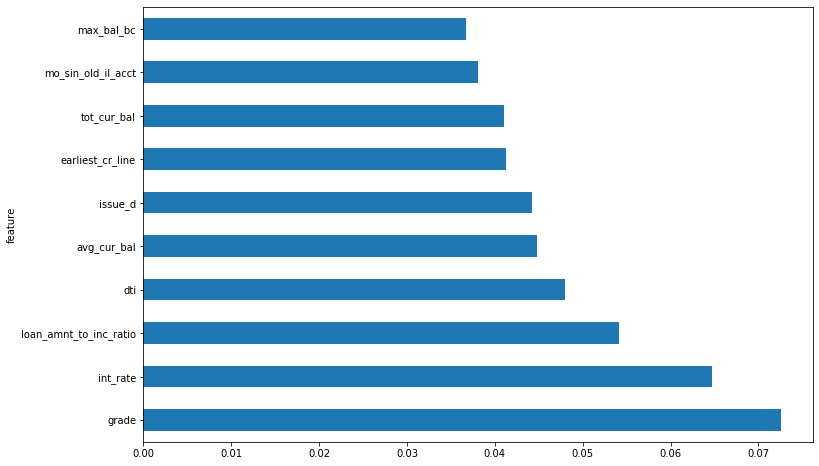

In [385]:
feat_imp = pd.DataFrame({'feature' : X_train_dup[to_keep].columns, 'imp' : m_rf2.feature_importances_}).sort_values(by='imp', ascending = False)
feat_imp[:10].plot('feature', 'imp', 'barh', figsize=(12,8), legend = False);

In [386]:
valid_preds = m_rf2.predict(X_valid[to_keep])
print(metrics.classification_report(y_valid, valid_preds))
print(metrics.confusion_matrix(y_valid, valid_preds))

              precision    recall  f1-score   support

           0       0.44      0.33      0.37     12962
           1       0.83      0.89      0.86     47960

    accuracy                           0.77     60922
   macro avg       0.63      0.61      0.61     60922
weighted avg       0.75      0.77      0.75     60922

[[ 4226  8736]
 [ 5486 42474]]


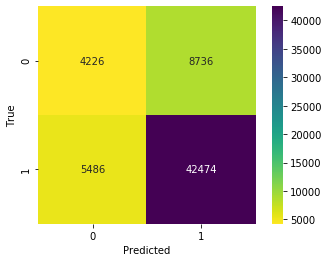

In [387]:
cm = metrics.confusion_matrix(y_valid, valid_preds)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

We are moving in the right direction. We have increased precision for class 1 and recall for class 0. Now, it seems like the model is still more comfortable predicting class 1 than 0, so let's feed another duplicate of class 0 set and force the model to train trees on a different subset of features, as there is information that is not being collected to correctly distinguish bad loans from the good ones.

## 3.3 Third and Final Random Forest Model
At this point we are not going to add any more class 0 data. We are going to concern ourselves only with hyperparameter tuning.

In [388]:
to_keep = feat_imp1[feat_imp1.imp > 0.01].feature
print(len(to_keep)); print(len(feat_imp1.feature))

45
145


In [461]:
# Hyperparameter tuning

dup_idxs = y_train[y_train == 0].index
dup_tr_df = X_train.loc[dup_idxs]
X_train_dup = pd.concat([X_train, dup_tr_df, dup_tr_df, dup_tr_df], axis = 0) #
y_train_dup = pd.concat([y_train, y_train[dup_idxs], y_train[dup_idxs], y_train[dup_idxs]], axis = 0) # 


leaf_num = []
v_precision_scores = []
v_accuracy_scores = []
v_recall_scores = []

t_precision_scores = []
t_accuracy_scores = []
t_recall_scores = []
    
for i in range(1, 26, 3):
    print('working on {}'.format(i))
    m = RandomForestClassifier(n_jobs = -1, min_samples_leaf = i)
    m.fit(X_train_dup[to_keep], y_train_dup)
    
    valid_pred = m.predict(X_valid[to_keep])
    train_pred = m.predict(X_train_dup[to_keep])
    
    leaf_num.append(i)
    v_precision_scores.append(metrics.precision_score(y_valid, valid_pred))
    v_accuracy_scores.append(metrics.accuracy_score(y_valid, valid_pred))
    v_recall_scores.append(metrics.recall_score(y_valid, valid_pred))
    
    t_precision_scores.append(metrics.precision_score(y_train_dup, train_pred))
    t_accuracy_scores.append(metrics.accuracy_score(y_train_dup, train_pred))
    t_recall_scores.append(metrics.recall_score(y_train_dup, train_pred))

working on 1
working on 4
working on 7
working on 10
working on 13
working on 16
working on 19
working on 22
working on 25


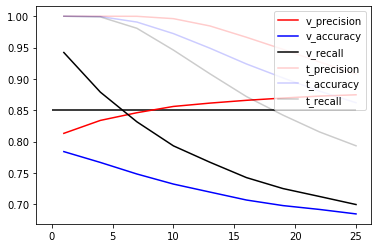

In [462]:
leaf_num = [*range(1, 26, 3)]

plt.plot(leaf_num, v_precision_scores, c= 'r', label = 'v_precision')
plt.plot(leaf_num, v_accuracy_scores, c = 'b', label = 'v_accuracy')
plt.plot(leaf_num, v_recall_scores, c = 'black', label = 'v_recall')

plt.plot(leaf_num, t_precision_scores, c= 'r', label = 't_precision', alpha = 0.2)
plt.plot(leaf_num, t_accuracy_scores, c = 'b', label = 't_accuracy', alpha = 0.2)
plt.plot(leaf_num, t_recall_scores, c = 'black', label = 't_recall', alpha = 0.2)
plt.hlines(0.85, xmin = 0, xmax = 25)
plt.legend(loc='upper right');

Optimal value of min_samples_lef is 11, which gives us a precision score of just above 86% on a validation set

Now, let's perform similar process with max_features

In [446]:
# Hyperparameter tuning

dup_idxs = y_train[y_train == 0].index
dup_tr_df = X_train.loc[dup_idxs]
X_train_dup = pd.concat([X_train, dup_tr_df, dup_tr_df, dup_tr_df], axis = 0) #
y_train_dup = pd.concat([y_train, y_train[dup_idxs], y_train[dup_idxs], y_train[dup_idxs]], axis = 0) # 


leaf_num = []
vv_precision_scores = []
vv_accuracy_scores = []
vv_recall_scores = []

tt_precision_scores = []
tt_accuracy_scores = []
tt_recall_scores = []
    
for i in range(1, 11):
    print('working on {}'.format(i))
    m = RandomForestClassifier(n_jobs = -1, min_samples_leaf = 10, max_features = i/10)
    m.fit(X_train_dup[to_keep], y_train_dup)
    
    valid_pred = m.predict(X_valid[to_keep])
    train_pred = m.predict(X_train_dup[to_keep])
    
    leaf_num.append(i)
    vv_precision_scores.append(metrics.precision_score(y_valid, valid_pred))
    vv_accuracy_scores.append(metrics.accuracy_score(y_valid, valid_pred))
    vv_recall_scores.append(metrics.recall_score(y_valid, valid_pred))
    
    tt_precision_scores.append(metrics.precision_score(y_train_dup, train_pred))
    tt_accuracy_scores.append(metrics.accuracy_score(y_train_dup, train_pred))
    tt_recall_scores.append(metrics.recall_score(y_train_dup, train_pred))

working on 1
working on 2
working on 3
working on 4
working on 5
working on 6
working on 7
working on 8
working on 9
working on 10


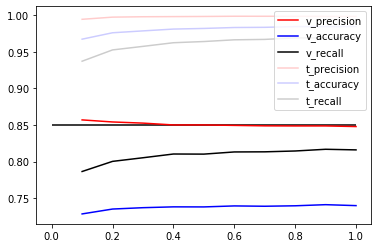

In [460]:
x_scaled = np.array([*range(1, 11)])/10

plt.plot(x_scaled, vv_precision_scores, c= 'r', label = 'v_precision')
plt.plot(x_scaled, vv_accuracy_scores, c = 'b', label = 'v_accuracy')
plt.plot(x_scaled, vv_recall_scores, c = 'black', label = 'v_recall')

plt.plot(x_scaled, tt_precision_scores, c= 'r', label = 't_precision', alpha = 0.2)
plt.plot(x_scaled, tt_accuracy_scores, c = 'b', label = 't_accuracy', alpha = 0.2)
plt.plot(x_scaled, tt_recall_scores, c = 'black', label = 't_recall', alpha = 0.2)
plt.hlines(0.85, xmin = 0, xmax = 1)
plt.legend(loc='upper right');

Looks like we get the best overall max_features hyperparameter is 0.3

Based on all the previous work we have done with hyperparameter tuning we are going to train our last model with these parameters and set n_estimators paramter to 300 to make it most robust

In [470]:
# Random Forest Model 3.0 with upsampled values and modified hyperparameters
dup_idxs = y_train[y_train == 0].index
dup_tr_df = X_train.loc[dup_idxs]
X_train_dup = pd.concat([X_train, dup_tr_df, dup_tr_df, dup_tr_df], axis = 0) #
y_train_dup = pd.concat([y_train, y_train[dup_idxs], y_train[dup_idxs], y_train[dup_idxs]], axis = 0) # 

m_rf3 = RandomForestClassifier(n_jobs = -1, min_samples_leaf = 11, max_features = 0.3, n_estimators = 300)
m_rf3.fit(X_train_dup[to_keep], y_train_dup)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [471]:
print_score(m_rf3, X_train_dup[to_keep], X_valid[to_keep], y_train_dup, y_valid)

,train_rmse,valid_rmse,train_recall,valid_recall,train_precision,valid_precision,train_accuracy,valid_accuracy
0,0.158909,0.515143,0.950879,0.798957,0.996404,0.854492,0.974748,0.734628


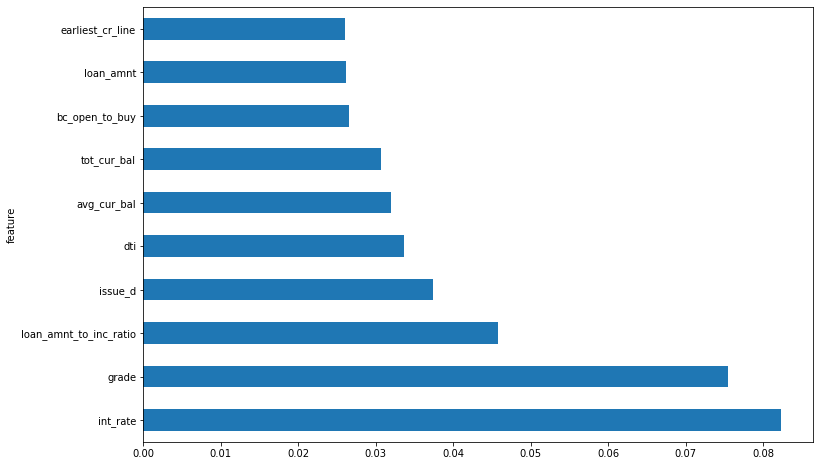

In [472]:
feat_imp = pd.DataFrame({'feature' : X_train_dup[to_keep].columns, 'imp' : m_rf3.feature_importances_}).sort_values(by='imp', ascending = False)
feat_imp[:10].plot('feature', 'imp', 'barh', figsize=(12,8), legend = False);

In [473]:
valid_preds = m_rf3.predict(X_valid[to_keep])
print(metrics.classification_report(y_valid, valid_preds))
print(metrics.confusion_matrix(y_valid, valid_preds))

              precision    recall  f1-score   support

           0       0.40      0.50      0.44     12962
           1       0.85      0.80      0.83     47960

    accuracy                           0.73     60922
   macro avg       0.63      0.65      0.63     60922
weighted avg       0.76      0.73      0.74     60922

[[ 6437  6525]
 [ 9642 38318]]


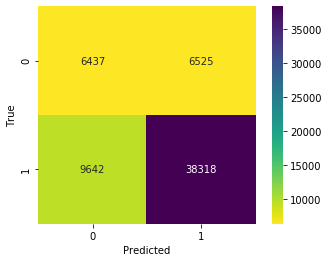

In [474]:
cm = metrics.confusion_matrix(y_valid, valid_preds)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

Our final model is looking pretty good. Although we have sacrificed some of the overall accuracy of the model, we are more confident in our selected loans being paid off. We now have 85% precision when claiming that a particular loan will be paid off. 15% misclassification rate for this model can be seen as high, but this model should not be a sole determiner whether one founds a loan. It should be used as one of many tools helping you along the way. It can even help by narrowing down a universe of loan from a few thousands to a handful, where we know 15% might default and that's where the human expertise can come in to further polish the investment process.

# 4. Tree interpreter

It is important to understand WHY the model is making a certain prediction - treeinterpreter does exactly that. The RF model creates multiple trees by creating best splits in data. Each group has an average class associated with the split. What treeinterpreter does is it traces the values of the particular row with the RF splits and records the marginal change in dependent class, dependent variable. So that we can see how each variable contributed to the final prediction.

Let us first visualize a simple tree to have a clear image of what is going on inside each random forest.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0719081 to fit



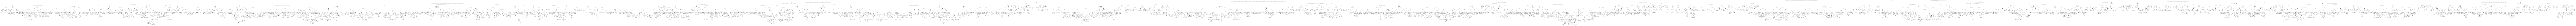

In [477]:
# Load libraries

from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(m_rf3.estimators_[0], out_file=None, 
                                feature_names=X_train[to_keep].columns)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [478]:
from treeinterpreter import treeinterpreter as ti

In [479]:
row = X_valid[to_keep].values[None,0]; row

array([[1.74700000e+01, 8.19672131e-03, 1.05600000e+01, 4.00000000e+00,
        2.27070000e+04, 4.54100000e+03, 2.49800000e+03, 1.20432960e+18,
        1.00000000e-01, 1.00000000e-01, 1.20000000e+02, 1.00000000e+03,
        5.10000000e+04, 2.00000000e+00, 2.50000000e+03, 2.00000000e+00,
        2.50000000e+03, 8.60000000e+01, 9.50000000e+01, 2.27050000e+04,
        7.07000000e+02, 9.00000000e+00, 1.51986240e+18, 1.00000000e+00,
        1.70000000e+01, 4.30000000e+01, 1.00000000e+00, 1.00000000e+00,
        2.00000000e+00, 7.00000000e+00, 9.00000000e+00, 1.00000000e+00,
        5.00000000e+00, 2.00000000e+00, 1.00000000e+00, 2.00000000e+00,
        3.00000000e+00, 3.00000000e+00, 9.00000000e+00, 8.89000000e+01,
        0.00000000e+00, 2.00000000e+00, 6.10000000e+01, 3.00000000e+00,
        2.00000000e+00]])

In [480]:
prediction, bias, contributions = ti.predict(m_rf3, row)

In [499]:
prediction[0][1], bias[0][1]
idxs = np.argsort(contributions[0][:, 1])
[o for o in zip(X_valid[to_keep].columns[idxs], X_valid[to_keep].iloc[0][idxs], contributions[0][:, 1][idxs])]

[('grade', 4.0, -0.07331268361455721),
 ('int_rate', 17.47, -0.04077161573856101),
 ('avg_cur_bal', 4541.0, -0.01609105240826752),
 ('tot_cur_bal', 22707.0, -0.014565852321958372),
 ('mths_since_recent_inq', 1.0, -0.01421600832403793),
 ('bc_open_to_buy', 2498.0, -0.010196373587138019),
 ('mo_sin_rcnt_rev_tl_op', 1.0, -0.00889824637452713),
 ('earliest_cr_line', 1.2043296e+18, -0.008243093864162599),
 ('num_rev_accts', 2.0, -0.005729208273050436),
 ('mths_since_recent_bc', 1.0, -0.005719109577739652),
 ('issue_d_Month', 3.0, -0.0042310239817274255),
 ('num_bc_tl', 2.0, -0.0037259582848808022),
 ('max_bal_bc', 2.0, -0.003322596410254775),
 ('mo_sin_rcnt_tl', 1.0, -0.0024312714352336543),
 ('mo_sin_old_il_acct', 120.0, -0.002303781925798165),
 ('total_bc_limit', 2500.0, -0.002222083586925814),
 ('addr_state', 43.0, -0.0016931542431329165),
 ('earliest_cr_line_Week', 9.0, -0.0014865974827824246),
 ('avg_fico', 707.0, -0.0013481785918114612),
 ('issue_d_Week', 9.0, -0.0008535460202562765),

Above is an example of interpreting how a random forest is making a prediction and how each feature is contributing to its decision.